# UXSS 2022 - Protein crystallography

## Exercise 1

### A - Import btx and instantiate a run diagnostic

In [1]:
import sys
sys.path.append("/cds/sw/package/autosfx/btx")

In [2]:
from btx.diagnostics.run import *

In [3]:
rd = RunDiagnostics('xpptut15', 580, 'jungfrau4M')

### B - Compute run stats on a subset of N images
- How long did it take?
- How long would it take on the whole run?

In [6]:
import time
import numpy as np

times = []
for n_images in np.arange(10,110,30):
    start_time = time.time()
    rd = RunDiagnostics('xpptut15', 580, 'jungfrau4M')
    rd.compute_run_stats(max_events=n_images)
    times.append(time.time() - start_time)
    print(f'It took {time.time() - start_time} s for {n_images} images')

Rank 0, no. empty images: 0, no. excluded images: 0
It took 17.80680012702942 s for 10 images
Rank 0, no. empty images: 0, no. excluded images: 0
It took 33.15417194366455 s for 40 images
Rank 0, no. empty images: 0, no. excluded images: 0
It took 48.186522006988525 s for 70 images
Rank 0, no. empty images: 0, no. excluded images: 0
It took 64.97698259353638 s for 100 images


In [64]:
rd = RunDiagnostics('xpptut15', 580, 'jungfrau4M')
print(f'Total number of images in the run: {rd.psi.max_events}')

Total number of images in the run: 35888


### C - Visualize the various powder images

/cds/sw/package/autosfx/btx/btx/diagnostics/run.py:60: RuntimeWarning: invalid value encountered in sqrt
  self.powders_final['std'] = np.sqrt(powder_sqr / float(total_n_proc) - np.square(self.powders_final['avg']))


Rank 0, no. empty images: 0, no. excluded images: 0


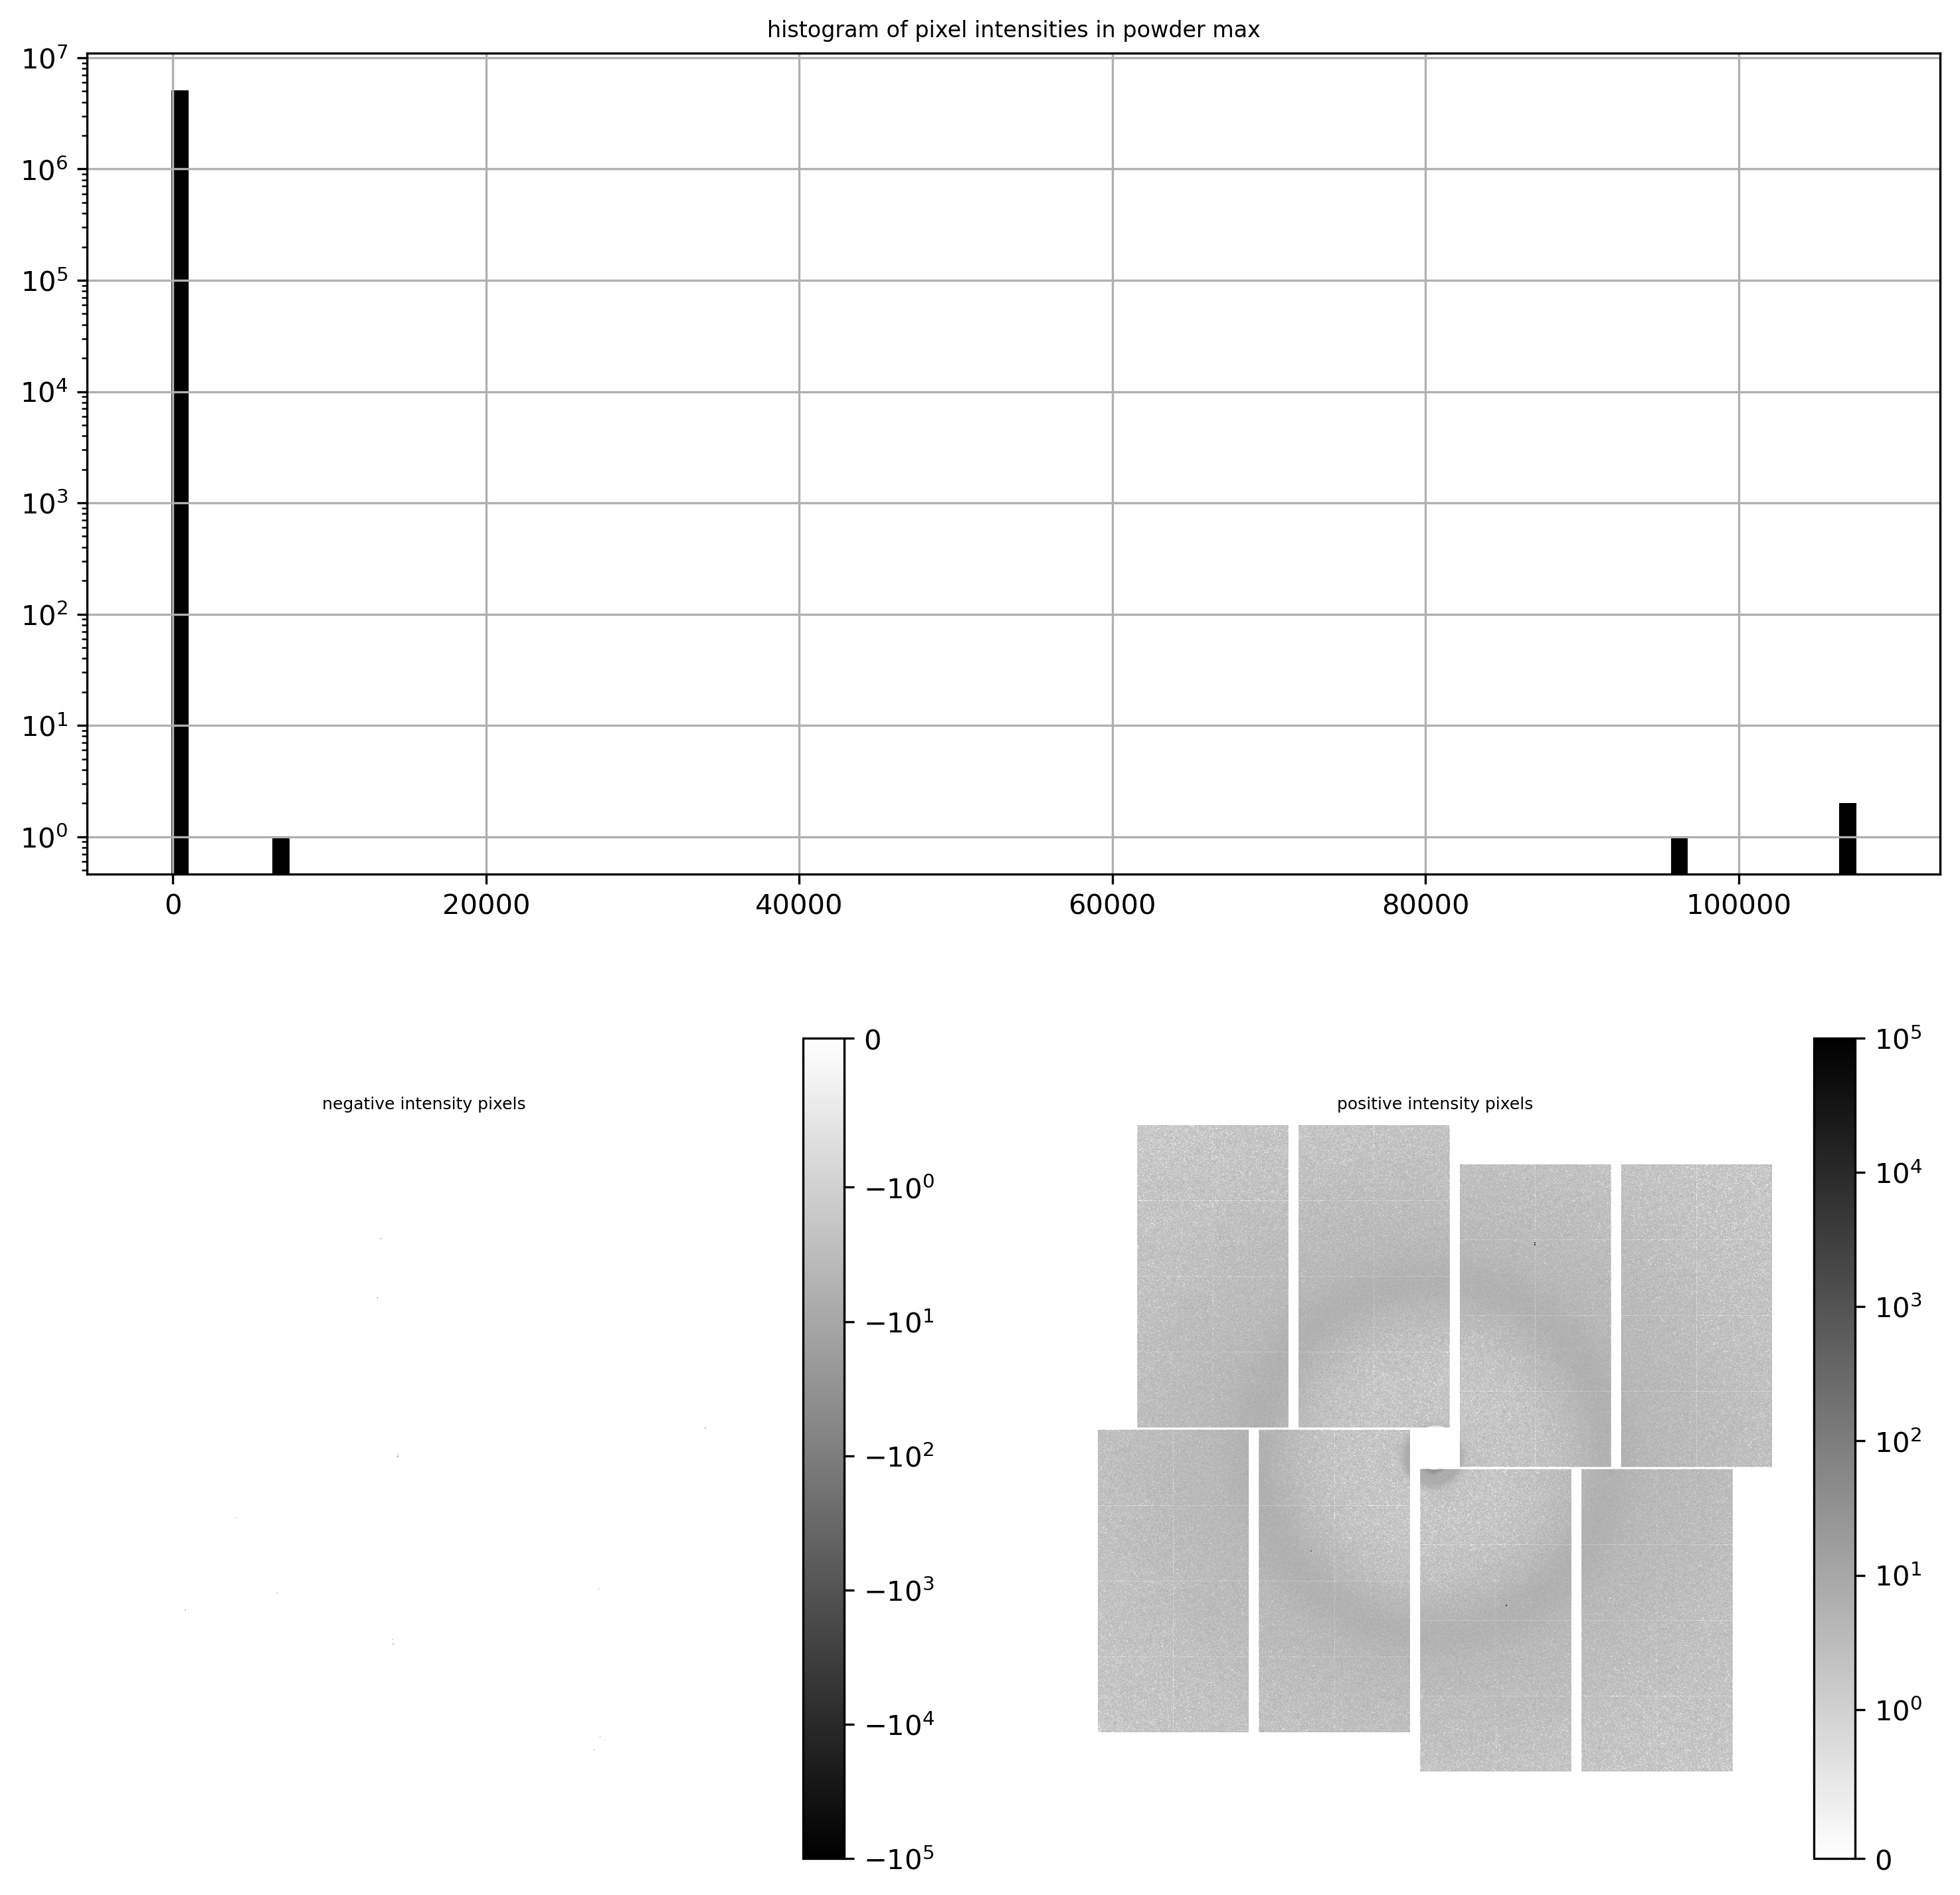

In [66]:
rd.compute_run_stats(max_events=50)
rd.visualize_powder()

In [67]:
def plot_powders(powders, mask=None):
    import matplotlib.colors as colors
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(9,6), dpi=180)

    powder_type = ['max', 'avg', 'std']

    for idx in np.arange(3):
        powder = powders[powder_type[idx]]
        if mask is not None:
            powder *= mask
        powder[ np.isnan(powder) ] = 0 
        vmin = np.min(powder.flatten())
        vmax = np.max(powder.flatten())
        axs[0,idx].imshow(powder, norm=colors.SymLogNorm(linthresh=1., linscale=1., vmin=vmin, vmax=vmax))
        axs[0,idx].set_title(f'Powder {powder_type[idx]}')
        axs[1,idx].hist(powder.flatten(), bins=5000, log=True, range=(vmin,vmax),  color='gray')
        axs[1,idx].set_xscale('symlog')
        axs[1,idx].set_title('Pixel statistics')

    plt.tight_layout()
    plt.show()

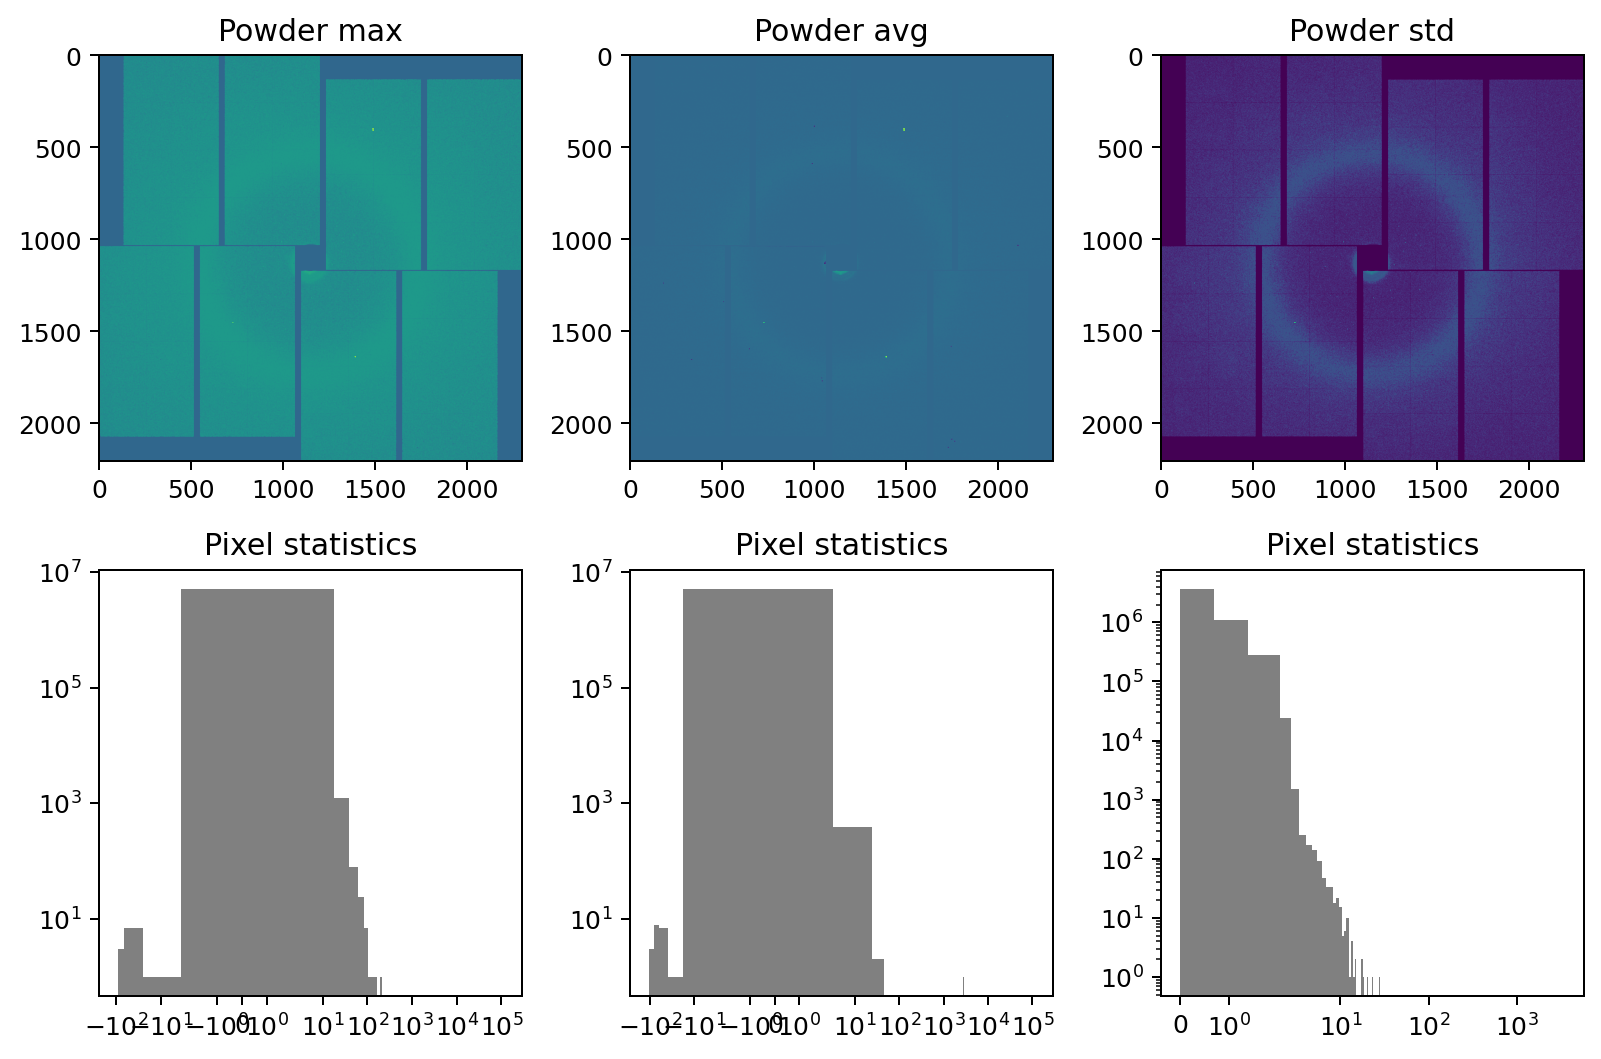

In [68]:
plot_powders(rd.powders_final)

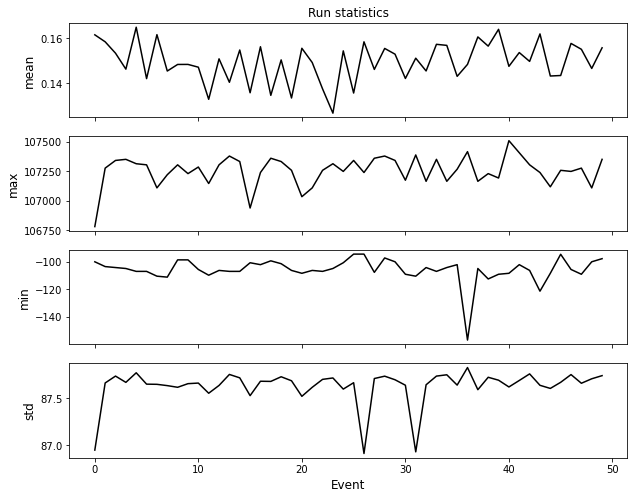

In [69]:
rd.visualize_stats()

### D - Identify bad pixels, make a mask and revisit stats above

In [83]:
from btx.interfaces.mask_interface import *
mi = MaskInterface('xpptut15', 580, 'jungfrau4M')

In [84]:
mi.generate_from_psana_run((-10,5000), n_images=10)

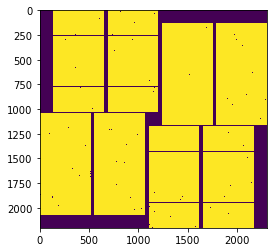

In [85]:
mask = mi.mask
mask_assembled = assemble_image_stack_batch(mask, rd.pixel_index_map)
plt.imshow(mask_assembled, vmax=1, interpolation='None')

/cds/sw/package/autosfx/btx/btx/diagnostics/run.py:60: RuntimeWarning: invalid value encountered in sqrt
  self.powders_final['std'] = np.sqrt(powder_sqr / float(total_n_proc) - np.square(self.powders_final['avg']))


Rank 0, no. empty images: 0, no. excluded images: 0


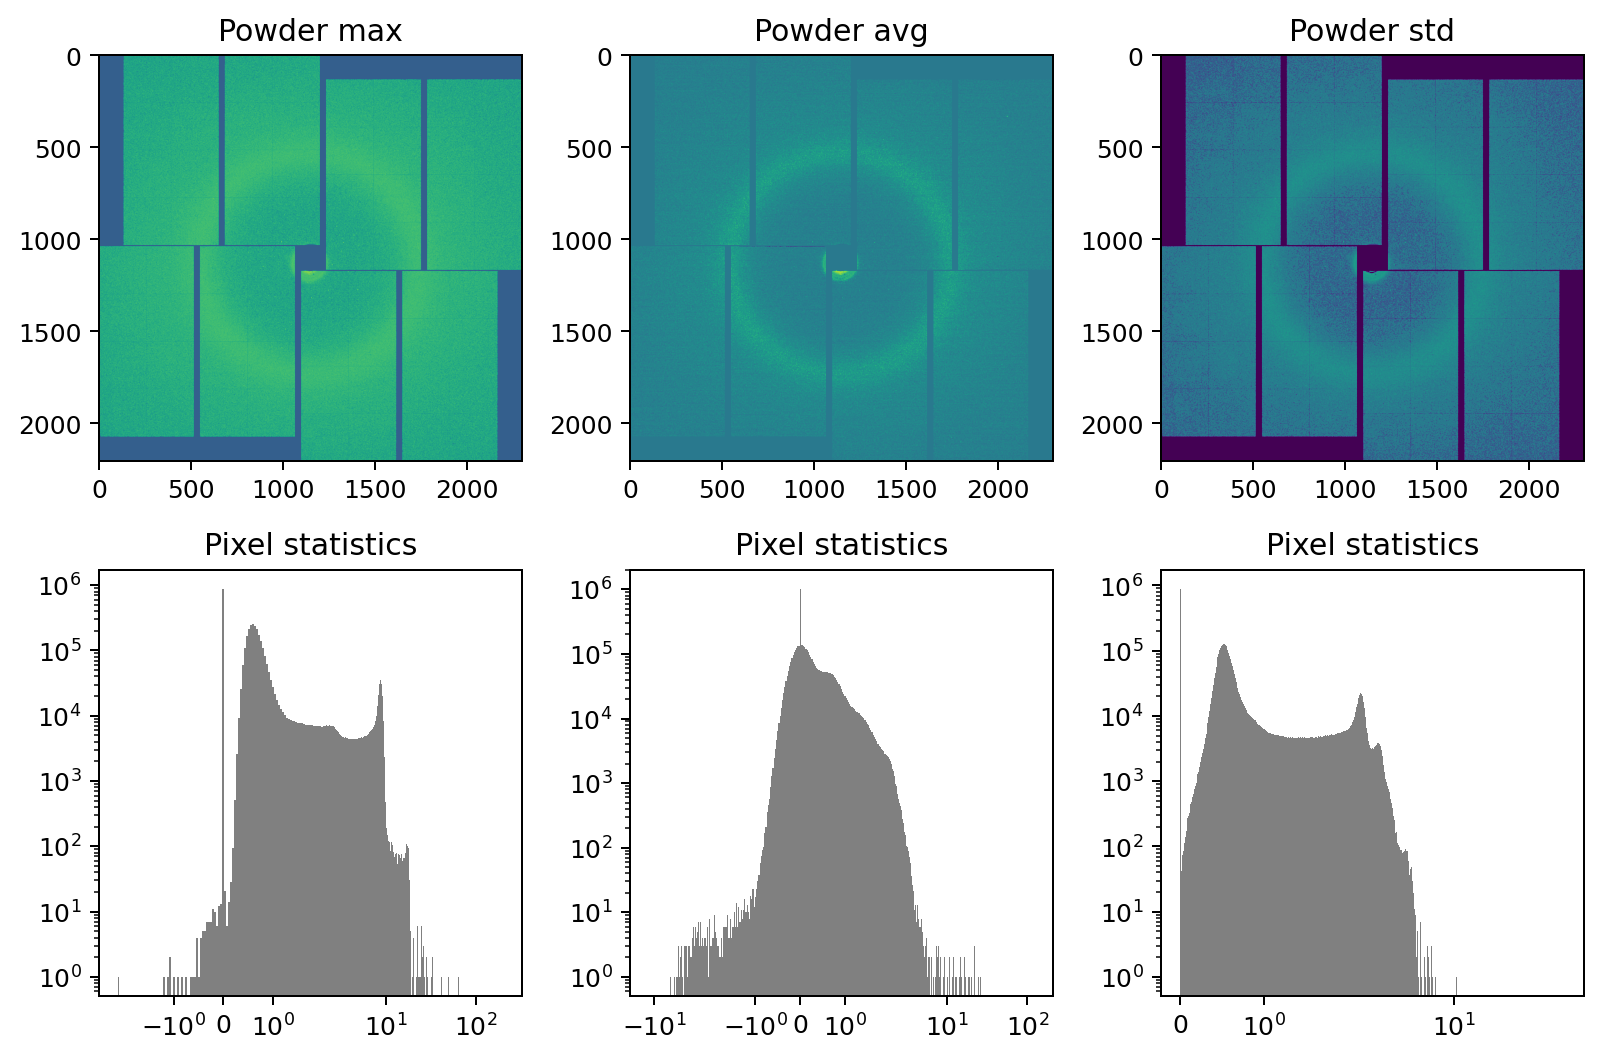

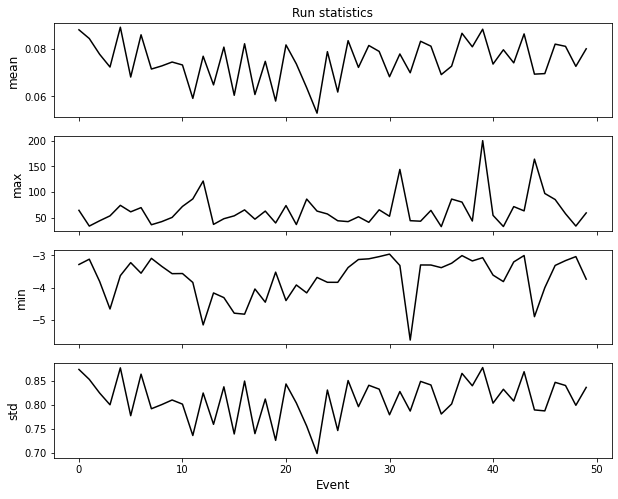

In [86]:
rd.compute_run_stats(max_events=50, mask=mask)
plot_powders(rd.powders_final, mask=mask_assembled)
rd.visualize_stats()

/cds/sw/package/autosfx/btx/btx/diagnostics/run.py:60: RuntimeWarning: invalid value encountered in sqrt
  self.powders_final['std'] = np.sqrt(powder_sqr / float(total_n_proc) - np.square(self.powders_final['avg']))


Rank 0, no. empty images: 0, no. excluded images: 0


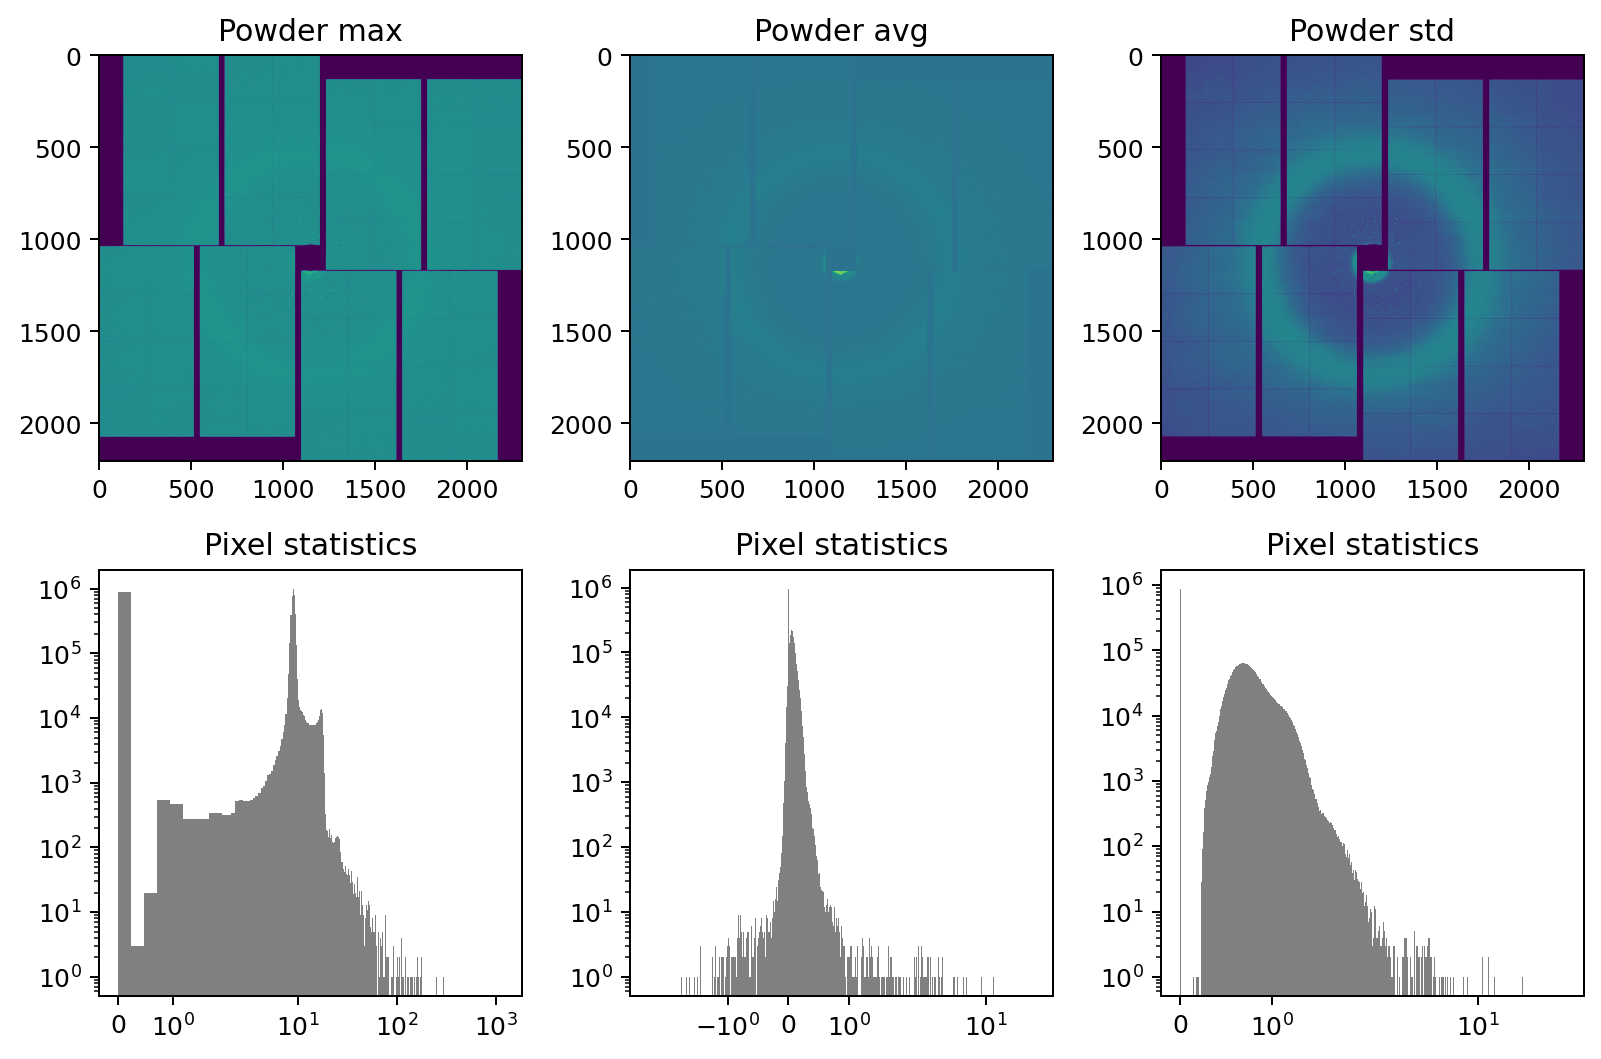

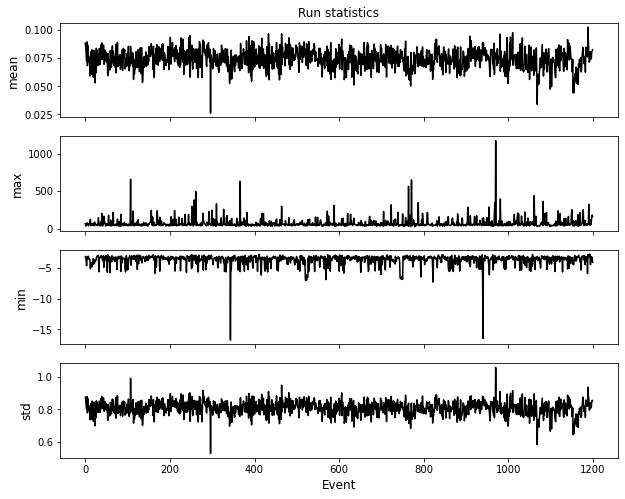

In [87]:
rd = RunDiagnostics('xpptut15', 580, 'jungfrau4M')
rd.compute_run_stats(max_events=1200, mask=mask)
plot_powders(rd.powders_final, mask=mask_assembled)
rd.visualize_stats()

In [101]:
photon_energy =  1e7 * 1.23984197386209e-06 / rd.psi.get_wavelength()
print(f'Photon energy: {beam_energy:.2f} keV')

Photon energy: 8.89 keV


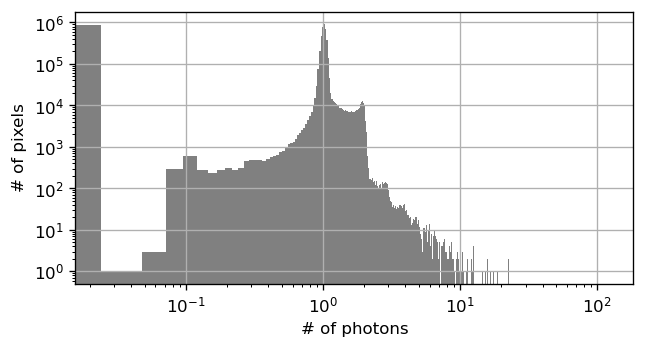

In [103]:
fig = plt.figure(figsize=(6,3),dpi=120)
plt.hist(rd.powders_final['max'].flatten()/photon_energy, bins=5000, log=True, color='gray', range=(0,120))
plt.xlabel('# of photons')
plt.ylabel('# of pixels')
plt.xscale('log')
plt.grid()
plt.show()

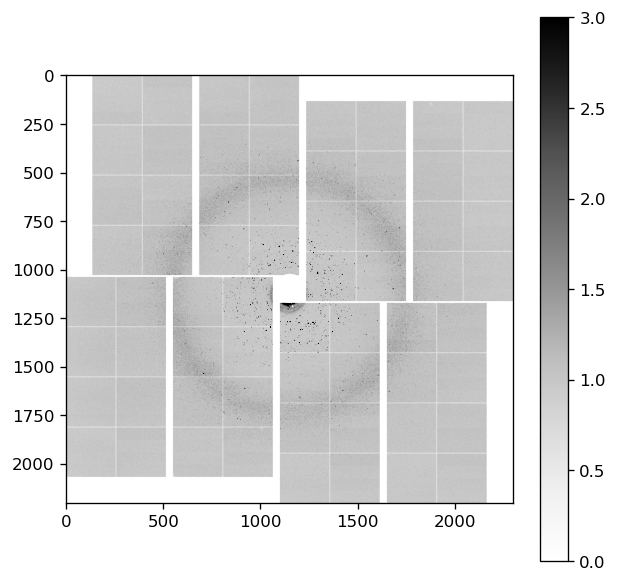

In [107]:
fig = plt.figure(figsize=(6,6),dpi=120)
plt.imshow(rd.powders_final['max']/photon_energy, vmin=0, vmax=3, cmap='Greys')
plt.colorbar()
plt.show()

## Exercise 2 - Peak Finding

In [108]:
!mkdir uxss2022

In [110]:
from btx.processing.peak_finder import *
pf = PeakFinder('xpptut15', 580, 'jungfrau4M', outdir='./uxss2022/')
pf.psi.max_events = 240
pf.find_peaks()
pf.curate_cxi()
pf.summarize()

self.iX.shape = (8, 512, 1024)
PV used to retrieve clen parameter: CXI:DS1:MMS:06.RBV
Value of clen parameter is: -439.9882 mm
Files with peaks: ['./uxss2022/xpptut15_r0580_0.cxi']


In [112]:
import h5py
f = h5py.File('./uxss2022/xpptut15_r0580_0.cxi', 'r')
for key in list(f.keys()):
    print(f'{key}')
    for subkey in list(f[key].keys()):
        print(f'... {subkey}')

LCLS
... detector_1
... eventNumber
... fiducial
... machineTime
... machineTimeNanoSeconds
... photon_energy_eV
entry_1
... data_1
... experimental_identifier
... result_1


In [113]:
powderhits = load_crystfel_mask('./uxss2022/xpptut15_r0580_0.cxi', dataset='/entry_1/data_1/powderHits')
powdermisses = load_crystfel_mask('./uxss2022/xpptut15_r0580_0.cxi', dataset='/entry_1/data_1/powderMisses')

In [114]:
powderhits_assembled = assemble_image_stack_batch(powderhits, rd.pixel_index_map)
powdermisses_assembled = assemble_image_stack_batch(powdermisses, rd.pixel_index_map)

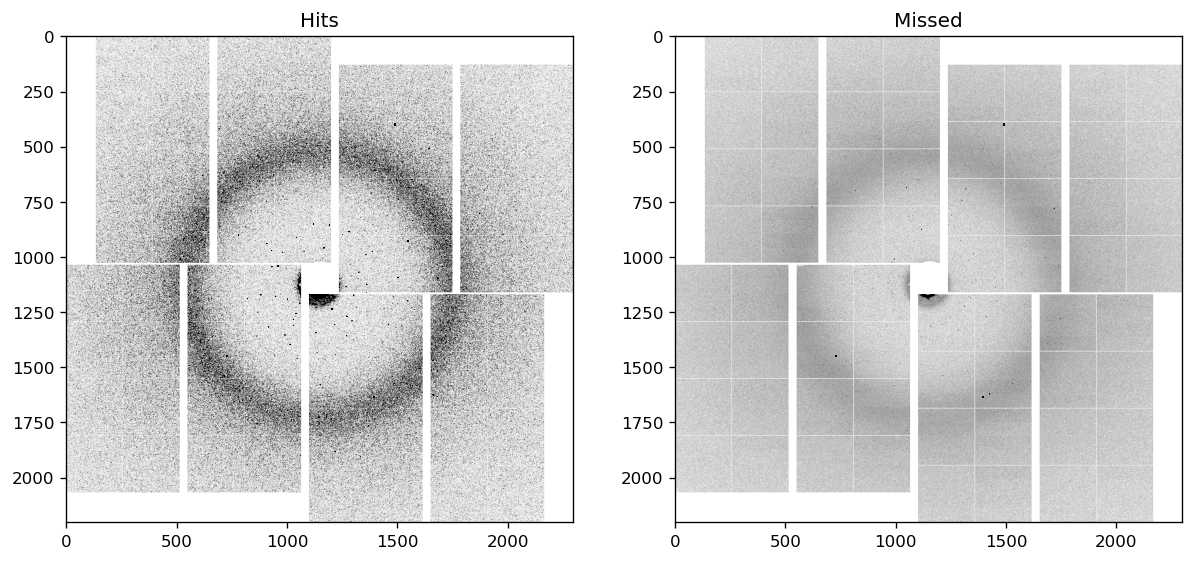

In [115]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,6),dpi=120)
vmaxhits = np.mean(powderhits_assembled) 
axs[0].imshow(powderhits_assembled, vmin=0, vmax=5,  cmap='Greys')
axs[0].set_title('Hits')
vmaxmisses = np.mean(powdermisses_assembled)
axs[1].imshow(powdermisses_assembled, vmin=0, vmax=5*vmaxmisses/vmaxhits, cmap='Greys')
axs[1].set_title('Missed')
plt.show()

In [116]:
hits = f['entry_1/data_1/data']
hits_reshape = np.array(hits).reshape((hits.shape[0], powderhits.shape[0], powderhits.shape[1], powderhits.shape[2]))
hits_assembled = np.zeros((hits.shape[0], powderhits_assembled.shape[0], powderhits_assembled.shape[1]))
for i in np.arange(hits.shape[0]):
    hits_assembled[i] = assemble_image_stack_batch(hits_reshape[i], rd.pixel_index_map)

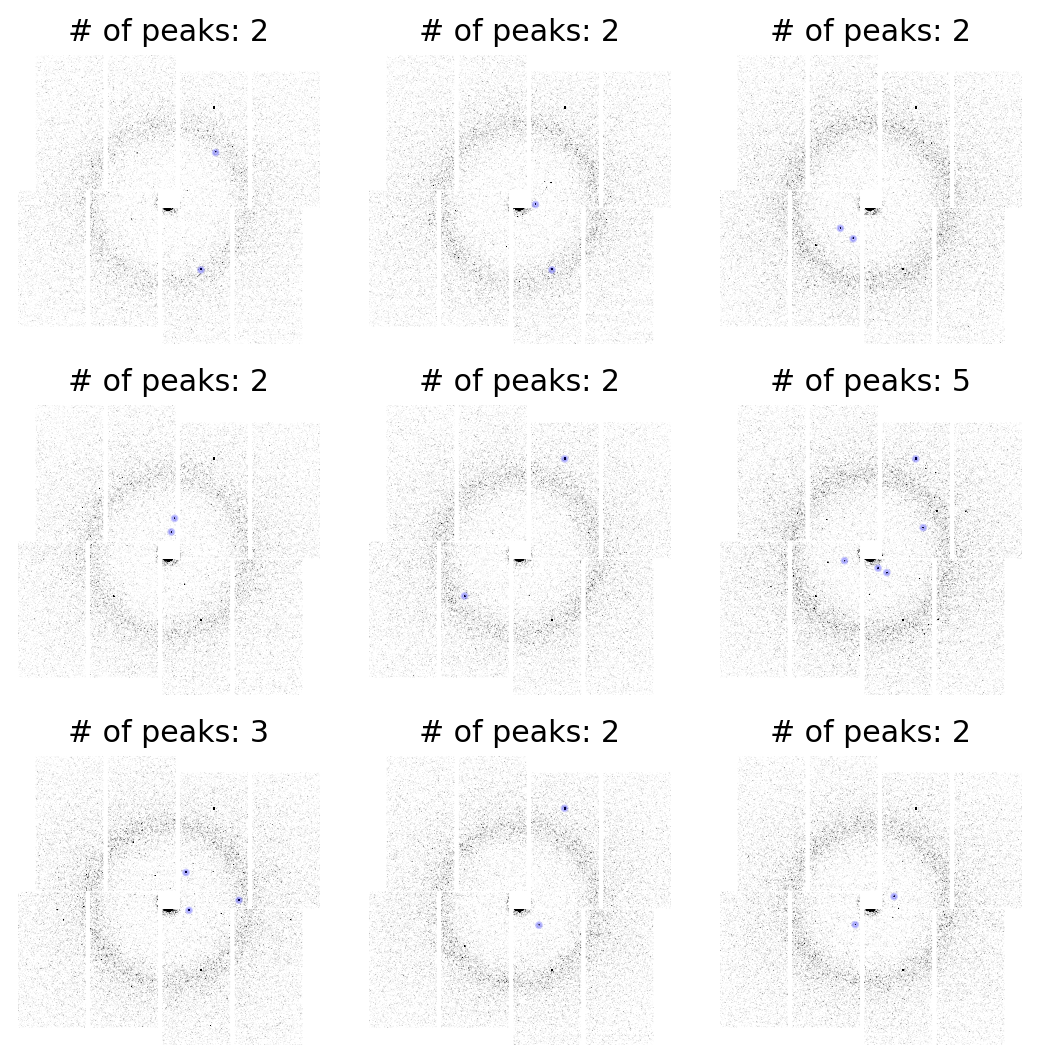

In [117]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(6,6),dpi=180)
k=0
for i in np.arange(3):
    for j in np.arange(3):
        axs[i,j].imshow(hits_assembled[k], vmin=0,vmax=1,cmap='Greys')
        axs[i,j].axis('off')
        npeaks = f['entry_1/result_1/nPeaks'][k]
        axs[i,j].set_title(f'# of peaks: {npeaks}')
        for ipeak in np.arange(npeaks):
            panel_num = f['entry_1/result_1/peakYPosRaw'][k] // 512
            panel_row = f['entry_1/result_1/peakYPosRaw'][k] % 512
            panel_col = f['entry_1/result_1/peakXPosRaw'][k]
            pixel = rd.pixel_index_map[int(panel_num[ipeak]), int(panel_row[ipeak]), int(panel_col[ipeak])]
            circle = plt.Circle((pixel[1],pixel[0]),20, color='blue', alpha=0.2)
            axs[i,j].add_patch(circle)
        k+=1
plt.tight_layout()
plt.show()

In [118]:
def plot_hits(hits, center=None, radius=10):
    if center is None:
        center = (powderhits_assembled.shape[0]//2, powderhits_assembled.shape[1]//2)
        center_list = list(center)
    else:
        center_list = list(center)
        center_list[0] += powderhits_assembled.shape[0]//2
        center_list[1] += powderhits_assembled.shape[1]//2
    fig = plt.figure(figsize=(6,6),dpi=120)
    ax = plt.gca()
    ax.imshow(hits, vmin=0, vmax=5,  cmap='Greys')
    circle_center = plt.Circle(tuple(center_list), 10, fill=True, color='blue')
    ax.add_patch(circle_center)
    circle = plt.Circle(tuple(center_list), radius, fill=False, color='blue')
    ax.add_patch(circle)
    plt.show()

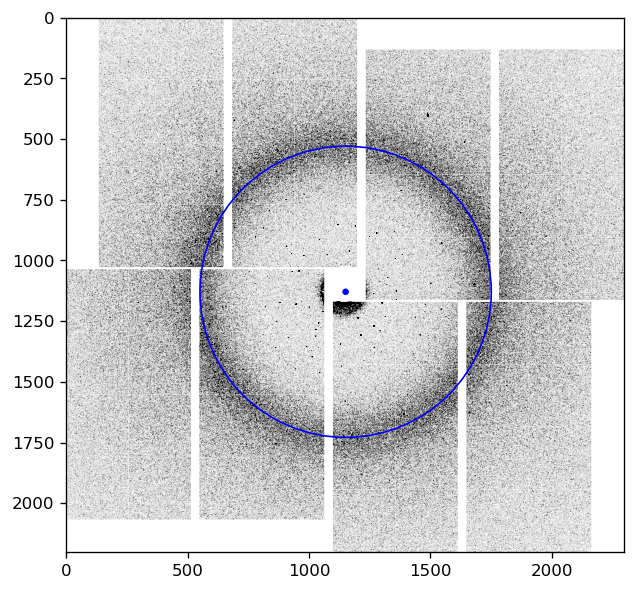

In [119]:
plot_hits(powderhits_assembled, center=(50,-20), radius=600)

In [120]:
from btx.misc.radial import *
def estimate_detector_distance(image, distance, center=None, mask=None):
    if center is None:
        center = (image.shape[0]//2, image.shape[1]//2)
        center_list = list(center)
    else:
        center_list = list(center)
        center_list[0] += image.shape[0]//2
        center_list[1] += image.shape[1]//2
    profile = radial_profile(image, center=center_list, threshold=0, mask=mask)
    q = pix2q(np.arange(profile.shape[0]), rd.psi.get_wavelength(), distance, 0.075)
    res = 1./q
    fig = plt.figure(figsize=(4,4),dpi=120)
    ax = plt.gca()
    ax.plot(q, profile, color='gray')
    ax.set_xticks(q[::300])
    ax.set_xticklabels([f'{r:.2f}' for r in res[::300]])
    ax.set_xlabel('Resolution (in A)')
    ax.set_ylabel('Radial intensity average')
    ax.set_yscale('log')

/cds/sw/ds/ana/conda1/inst/envs/ana-4.0.42-py3/lib/python3.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in true_divide


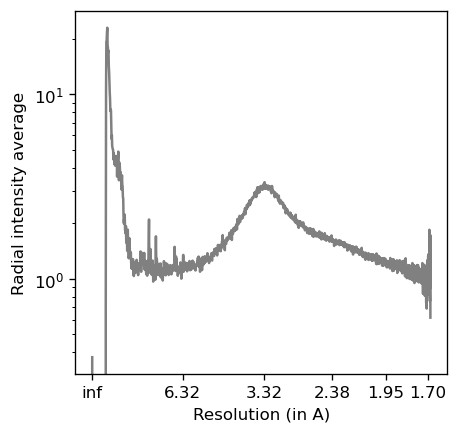

In [121]:
estimate_detector_distance(powderhits_assembled, 100, center=(50,-20), mask=mask_assembled)